In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd

# Part 1. Preparing

## 🌀 Data reading, cleaning and splitting to train, valid and test

In [2]:
df = pd.read_csv("/home/jovyan/work/homeworks/cv-1/hw_dataset/butterflies_and_moths.csv")

In [3]:
df.dtypes

class id      int64
filepaths    object
labels       object
data set     object
dtype: object

In [4]:
df.head(3)

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train


In [5]:
df = df.rename(columns={"class id": "class_id", "data set": "data_set"})
df["labels"] = df["labels"].str.lower()

In [6]:
df["class_id"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

#### Check for duplicates and NaN

In [7]:
num_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Dropped {num_rows - df.shape[0]} examples")

Dropped 0 examples


In [8]:
num_rows = df.shape[0]
df = df.dropna()
print(f"Dropped {num_rows - df.shape[0]} examples")

Dropped 0 examples


In [9]:
train_df = df[df["data_set"] == "train"]
valid_df = df[df["data_set"] == "valid"]
test_df = df[df["data_set"] == "test"]

assert train_df.shape[0] + valid_df.shape[0] + test_df.shape[0] == df.shape[0]

In [10]:
train_df.head(3)

,class_id,filepaths,labels,data_set
0,0,train/ADONIS/001.jpg,adonis,train
1,0,train/ADONIS/002.jpg,adonis,train
2,0,train/ADONIS/003.jpg,adonis,train


In [11]:
train_df.shape

(12594, 4)

## 🦋 Data analysis

In [12]:
import os
import cv2
import matplotlib.pyplot as plt

def display_image_grid(img_dir, images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(os.path.join(img_dir, image_filepath))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

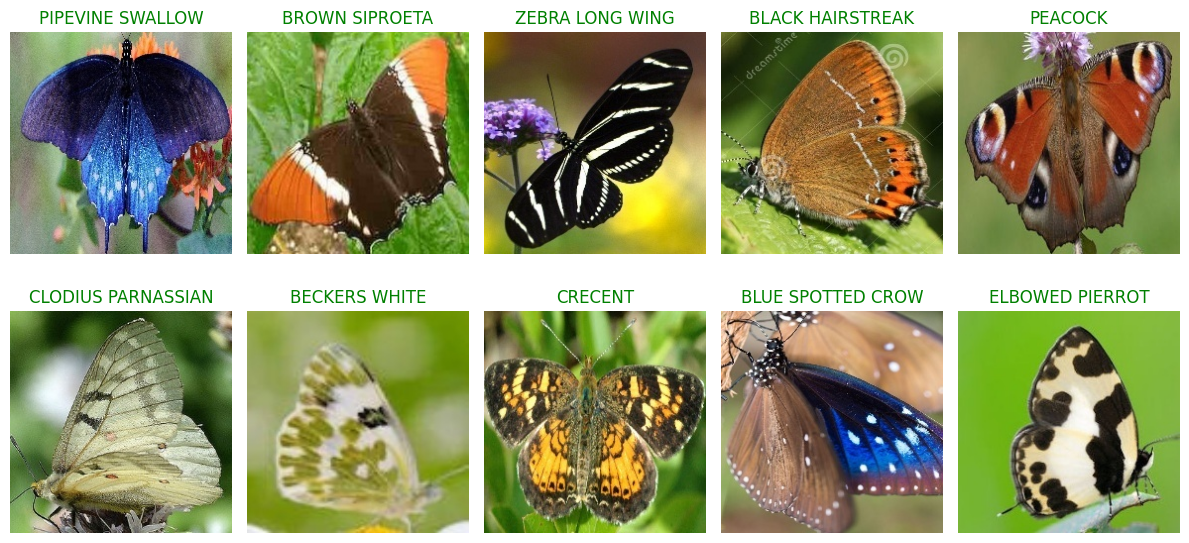

In [ ]:
img_dir = "/home/jovyan/work/homeworks/cv-1/hw_dataset"

display_image_grid(img_dir, train_df.sample(10)["filepaths"])

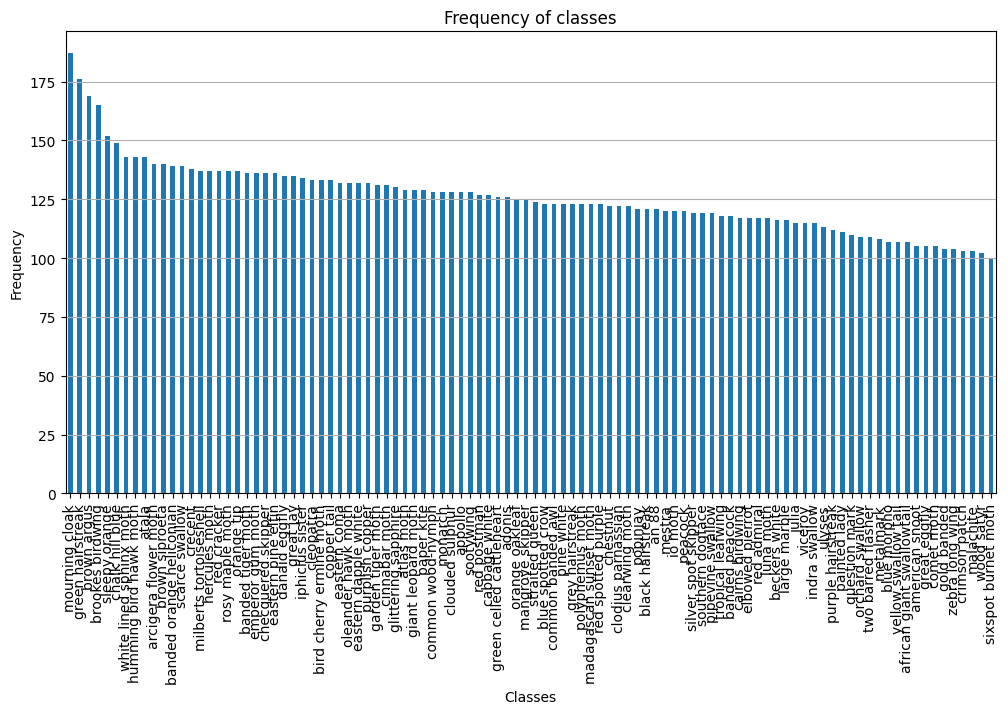

In [14]:
class_counts = train_df["labels"].value_counts()

plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Frequency of classes')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')  
plt.show()

#### Has train data disbalance? Answer: **Yes**

## 🗳️ Dataset

In [15]:
import os
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]["filepaths"])
        image = read_image(img_path, ImageReadMode.RGB)
        label = self.df.iloc[idx]["class_id"]
        if self.transform:
            image = self.transform(image)
        return image, label

## 🗿 Augmentations

In [16]:
# !sudo pip uninstall torchvision --yes
# !sudo pip install torchvision

In [16]:
import torchvision

torchvision.__version__
#torch.__version__

'0.20.0+cu124'

In [17]:
import torch
from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=(10, 30)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
img_dir = "/home/jovyan/work/homeworks/cv-1/hw_dataset"

train_dataset = CustomImageDataset(train_df, img_dir, transform=train_transform)
valid_dataset = CustomImageDataset(valid_df, img_dir, transform=test_transform)
test_dataset = CustomImageDataset(test_df, img_dir, transform=test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


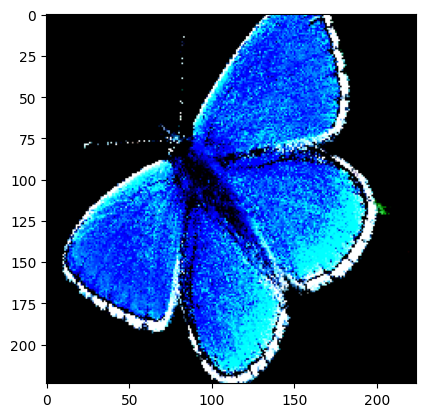

In [19]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

## 🚀 Dataloaders

In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 🏋️ Preparing for train

#### Do experiments determined

In [21]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

#### Metrics

In [22]:
import sklearn.metrics

def get_metrics(y_true, y_pred, y_pred_probabilies):
    return {
        "accuracy": sklearn.metrics.accuracy_score(y_true, y_pred),
        "f1": sklearn.metrics.f1_score(y_true, y_pred, average='micro'),
        "roc_auc": sklearn.metrics.roc_auc_score(y_true, y_pred_probabilies, multi_class="ovr", average="micro"),
    }

In [23]:
class MetricsTable:
    def __init__(self):
        self.metrics = pd.DataFrame(columns=["model", "accuracy", "f1", "roc_auc"])
        
    def add_result(self, model, accuracy, f1, roc_auc):
        self.metrics.loc[len(self.metrics)] = [model, accuracy, f1, roc_auc]
        
    def print_table(self):
        print(self.metrics)

#### Training loop

In [24]:
def training_loop(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    y_pred, y_true, y_pred_probabilites = [], [], []
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        predicted = predicted.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        probs = probs.detach().cpu().numpy()
        y_true.extend(labels)
        y_pred.extend(predicted)
        y_pred_probabilites.extend(probs)
        
    return train_loss, y_true, y_pred, y_pred_probabilites

#### Validation loop

In [25]:
def validation_loop(model, device, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    y_pred, y_true, y_pred_probabilites = [], [], []
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)
            predicted = predicted.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            probs = probs.detach().cpu().numpy()
            y_true.extend(labels)
            y_pred.extend(predicted)
            y_pred_probabilites.extend(probs)
            
    return valid_loss, y_true, y_pred, y_pred_probabilites

#### Fit model

In [26]:
def fit(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs):
    train_losses = []
    valid_losses = []
    test_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_y_true, train_y_pred, train_y_probs = training_loop(model, device, train_loader, optimizer, criterion)
        train_metrics = get_metrics(train_y_true, train_y_pred, train_y_probs)
        
        train_accuracy = train_metrics["accuracy"]
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_loss, valid_y_true, valid_y_pred, valid_y_probs = validation_loop(model, device, valid_loader, criterion)
        valid_metrics = get_metrics(valid_y_true, valid_y_pred, valid_y_probs)
        
        valid_accuracy = valid_metrics["accuracy"]
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2%} '
             )
        
    return model

#### Save model & Load model

In [48]:
import os

def model_save(model, name, checkpoints_dir="checkpoints"):
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    PATH = os.path.join(checkpoints_dir, f"{name}.pt")
    torch.save(model.state_dict(), PATH)
    
def load_model(model, name, checkpoints_dir="checkpoints"):
    PATH = os.path.join(checkpoints_dir, f"{name}.pt")
    model.load_state_dict(torch.load(PATH))
    model.eval()
    return model

#### Get device

In [28]:
!nvidia-smi

Tue Oct 22 08:32:06 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   42C    P0    75W / 300W |   2202MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:02:00.0 Off |                    0 |
|  0%   

In [29]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# 🧌 Part 2. Experiments 1

### Model 1

In [30]:
class SimpliestClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SimpliestClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

simpliest_model = SimpliestClassifier(num_classes=100)
simpliest_model = simpliest_model.to(device)

#### Optimizer & Loss

In [122]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simpliest_model.parameters(), lr=0.001)

In [144]:
NUM_EPOCHS = 5

simpliest_model = fit(simpliest_model, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(simpliest_model, "SimpliestClassifier")

Epoch [1/5], Training Loss: 14.2929, Training Accuracy: 70.42%, Validation Loss: 3.5036, Validation Accuracy: 27.60%, 
Epoch [2/5], Training Loss: 13.2731, Training Accuracy: 72.19%, Validation Loss: 3.3921, Validation Accuracy: 28.60%, 
Epoch [3/5], Training Loss: 12.3526, Training Accuracy: 74.29%, Validation Loss: 3.1703, Validation Accuracy: 32.80%, 
Epoch [4/5], Training Loss: 11.6109, Training Accuracy: 76.03%, Validation Loss: 3.4310, Validation Accuracy: 30.20%, 
Epoch [5/5], Training Loss: 10.8966, Training Accuracy: 77.35%, Validation Loss: 3.4279, Validation Accuracy: 31.40%, 


**Note**: there is a lot of epochs (maybe 20-25), cell has been restarted several times (sry for the bad logs)

### Model 2

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(100352, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

improved_model = ImprovedClassifier(num_classes=100)
improved_model = improved_model.to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

In [39]:
NUM_EPOCHS = 15

improved_model = fit(improved_model, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(improved_model, "ImprovedClassifier")

Epoch [1/15], Training Loss: 211.4072, Training Accuracy: 1.09%, Validation Loss: 4.5856, Validation Accuracy: 1.40% 
Epoch [2/15], Training Loss: 114.2718, Training Accuracy: 1.79%, Validation Loss: 4.5299, Validation Accuracy: 2.20% 
Epoch [3/15], Training Loss: 112.7027, Training Accuracy: 2.10%, Validation Loss: 4.4426, Validation Accuracy: 3.00% 
Epoch [4/15], Training Loss: 112.1190, Training Accuracy: 2.30%, Validation Loss: 4.3959, Validation Accuracy: 3.40% 
Epoch [5/15], Training Loss: 111.0947, Training Accuracy: 2.59%, Validation Loss: 4.3699, Validation Accuracy: 4.20% 
Epoch [6/15], Training Loss: 110.8347, Training Accuracy: 2.87%, Validation Loss: 4.3047, Validation Accuracy: 4.00% 
Epoch [7/15], Training Loss: 109.9284, Training Accuracy: 2.99%, Validation Loss: 4.3036, Validation Accuracy: 4.20% 
Epoch [8/15], Training Loss: 109.4190, Training Accuracy: 3.31%, Validation Loss: 4.2171, Validation Accuracy: 4.60% 
Epoch [9/15], Training Loss: 109.1206, Training Accuracy

So bad...

## Model 3

In [32]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(25088, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

simple_model = SimpleClassifier(num_classes=100)
simple_model = simple_model.to(device)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-3)

In [91]:
NUM_EPOCHS = 25

simple_model = fit(simple_model, device, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(simple_model, "SimpleModel")

Epoch [1/25], Training Loss: 406.3953, Training Accuracy: 6.90%, Validation Loss: 3.7029, Validation Accuracy: 12.60% 
Epoch [2/25], Training Loss: 283.6255, Training Accuracy: 28.06%, Validation Loss: 3.1944, Validation Accuracy: 21.80% 
Epoch [3/25], Training Loss: 221.6694, Training Accuracy: 42.84%, Validation Loss: 2.6611, Validation Accuracy: 33.40% 
Epoch [4/25], Training Loss: 180.0688, Training Accuracy: 51.99%, Validation Loss: 2.5511, Validation Accuracy: 34.20% 
Epoch [5/25], Training Loss: 154.3773, Training Accuracy: 57.96%, Validation Loss: 2.2797, Validation Accuracy: 42.60% 
Epoch [6/25], Training Loss: 137.8547, Training Accuracy: 62.24%, Validation Loss: 2.3701, Validation Accuracy: 39.80% 
Epoch [7/25], Training Loss: 123.1732, Training Accuracy: 65.79%, Validation Loss: 2.3934, Validation Accuracy: 39.80% 
Epoch [8/25], Training Loss: 109.8555, Training Accuracy: 69.47%, Validation Loss: 2.5725, Validation Accuracy: 37.20% 
Epoch [9/25], Training Loss: 103.4078, Tr

In [ ]:
new_simple_model = SimpleClassifier(num_classes=100)
load_model(new_simple_model, "SimpleModel")

# 🏎️ Transformers

## Model 4

In [33]:
import torch.nn as nn
from torchvision import models

class ModifiedViT(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(ModifiedViT, self).__init__()
        self.pretrained = pretrained_model
        self.pretrained.head = nn.Identity()  
        self.new_head = nn.Sequential(
            nn.Linear(1000, num_classes), 
        )

    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_head(x)
        return x

In [34]:
vit_b_16 = models.vit_b_16(pretrained=True)

modified_vit_b_16 = ModifiedViT(vit_b_16, num_classes=100)
modified_vit_b_16 = modified_vit_b_16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 85.5MB/s] 


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modified_vit_b_16.parameters(), lr=1e-3)

In [46]:
NUM_EPOCHS = 5

modified_vit_b_16 = fit(modified_vit_b_16, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(modified_vit_b_16, "ViT_b_16")

Epoch [1/5], Training Loss: 70.4942, Training Accuracy: 77.68%, Validation Loss: 1.1654, Validation Accuracy: 68.40% 
Epoch [2/5], Training Loss: 67.5678, Training Accuracy: 78.92%, Validation Loss: 1.0953, Validation Accuracy: 70.20% 
Epoch [3/5], Training Loss: 60.7942, Training Accuracy: 80.32%, Validation Loss: 1.0493, Validation Accuracy: 71.20% 
Epoch [4/5], Training Loss: 55.5361, Training Accuracy: 82.17%, Validation Loss: 0.8790, Validation Accuracy: 77.00% 
Epoch [5/5], Training Loss: 49.7930, Training Accuracy: 83.97%, Validation Loss: 1.1188, Validation Accuracy: 72.60% 


**Note**: there is a lot of epochs (maybe 20-25), cell has been restarted several times (sry for the bad logs)

## Model 5

In [35]:
vit_b_32 = models.vit_b_32(pretrained=True)

modified_vit_b_32 = ModifiedViT(vit_b_32, num_classes=100)
modified_vit_b_32 = modified_vit_b_32.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:19<00:00, 17.8MB/s] 


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modified_vit_b_32.parameters(), lr=1e-3)

In [39]:
NUM_EPOCHS = 10

modified_vit_b_32 = fit(modified_vit_b_32, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(modified_vit_b_32, "ViT_b_32")

Epoch [1/10], Training Loss: 27.1327, Training Accuracy: 90.92%, Validation Loss: 3.8640, Validation Accuracy: 45.80% 
Epoch [2/10], Training Loss: 24.7385, Training Accuracy: 91.73%, Validation Loss: 3.6663, Validation Accuracy: 46.60% 
Epoch [3/10], Training Loss: 22.4909, Training Accuracy: 92.47%, Validation Loss: 3.1796, Validation Accuracy: 53.20% 
Epoch [4/10], Training Loss: 22.8099, Training Accuracy: 92.23%, Validation Loss: 3.6104, Validation Accuracy: 50.00% 
Epoch [5/10], Training Loss: 20.6225, Training Accuracy: 93.08%, Validation Loss: 3.0590, Validation Accuracy: 49.40% 
Epoch [6/10], Training Loss: 20.9076, Training Accuracy: 92.73%, Validation Loss: 3.4426, Validation Accuracy: 49.60% 
Epoch [7/10], Training Loss: 19.0175, Training Accuracy: 93.39%, Validation Loss: 4.1127, Validation Accuracy: 47.00% 
Epoch [8/10], Training Loss: 18.9868, Training Accuracy: 93.69%, Validation Loss: 3.1758, Validation Accuracy: 52.80% 
Epoch [9/10], Training Loss: 15.1238, Training A

**Note**: there is a lot of epochs (maybe 20-25), cell has been restarted several times (sry for the bad logs)

# 🏄‍♂️ Transfer learning

## Model 6

In [36]:
from torchvision import models

class GoogleNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.network = models.googlenet(pretrained=True)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

In [108]:
googlenet = GoogleNet(num_classes=100)
googlenet = googlenet.to(device)

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [110]:
NUM_EPOCHS = 15

googlenet = fit(googlenet, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(googlenet, "GoogleNet")

Epoch [1/15], Training Loss: 52.7991, Training Accuracy: 61.86%, Validation Loss: 0.7086, Validation Accuracy: 84.20% 
Epoch [2/15], Training Loss: 9.4569, Training Accuracy: 90.85%, Validation Loss: 0.3252, Validation Accuracy: 91.60% 
Epoch [3/15], Training Loss: 5.0505, Training Accuracy: 94.74%, Validation Loss: 0.2799, Validation Accuracy: 93.80% 
Epoch [4/15], Training Loss: 3.3930, Training Accuracy: 96.41%, Validation Loss: 0.3286, Validation Accuracy: 90.40% 
Epoch [5/15], Training Loss: 2.4672, Training Accuracy: 97.40%, Validation Loss: 0.2536, Validation Accuracy: 94.60% 
Epoch [6/15], Training Loss: 1.9363, Training Accuracy: 97.90%, Validation Loss: 0.2472, Validation Accuracy: 94.20% 
Epoch [7/15], Training Loss: 1.6167, Training Accuracy: 98.23%, Validation Loss: 0.2879, Validation Accuracy: 92.20% 
Epoch [8/15], Training Loss: 1.3543, Training Accuracy: 98.60%, Validation Loss: 0.2687, Validation Accuracy: 93.80% 
Epoch [9/15], Training Loss: 1.0925, Training Accuracy:

## Model 7

In [37]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(nn.Module):
    def __init__(self, num_classes, freeze_features=True):
        super().__init__()
        self.base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        if freeze_features:
            for param in self.features.parameters():
                param.requires_grad = False

        enet_out_size = 2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output
    
resnet = ResNet50(num_classes=100)
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.3MB/s]


In [78]:
def count_frozen_params(model):
    frozen, trainable = 0, 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable += 1
        else:
            frozen += 1
            
    print(f"Frozen: {frozen} layers, trainable: {trainable} layers")

In [79]:
count_frozen_params(resnet)

Frozen: 159 layers, trainable: 4 layers


In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [81]:
NUM_EPOCHS = 3

resnet = fit(resnet, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

Epoch [1/3], Training Loss: 296.0256, Training Accuracy: 56.36%, Validation Loss: 2.0477, Validation Accuracy: 74.40% 
Epoch [2/3], Training Loss: 130.1564, Training Accuracy: 83.81%, Validation Loss: 1.3054, Validation Accuracy: 78.60% 
Epoch [3/3], Training Loss: 82.6013, Training Accuracy: 87.83%, Validation Loss: 1.0068, Validation Accuracy: 84.00% 


In [82]:
for param in resnet.parameters():
    param.requires_grad = True

In [83]:
NUM_EPOCHS = 15

resnet = fit(resnet, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)
model_save(resnet, "ResNet50")

Epoch [1/15], Training Loss: 37.1216, Training Accuracy: 89.65%, Validation Loss: 0.3309, Validation Accuracy: 91.40% 
Epoch [2/15], Training Loss: 18.3166, Training Accuracy: 94.55%, Validation Loss: 0.2768, Validation Accuracy: 92.60% 
Epoch [3/15], Training Loss: 12.6594, Training Accuracy: 95.88%, Validation Loss: 0.4513, Validation Accuracy: 89.60% 
Epoch [4/15], Training Loss: 9.8504, Training Accuracy: 96.83%, Validation Loss: 0.3007, Validation Accuracy: 93.40% 
Epoch [5/15], Training Loss: 8.3012, Training Accuracy: 97.28%, Validation Loss: 0.3868, Validation Accuracy: 91.60% 
Epoch [6/15], Training Loss: 8.4651, Training Accuracy: 97.32%, Validation Loss: 0.3353, Validation Accuracy: 92.40% 
Epoch [7/15], Training Loss: 6.2188, Training Accuracy: 98.09%, Validation Loss: 0.2294, Validation Accuracy: 94.40% 
Epoch [8/15], Training Loss: 4.2462, Training Accuracy: 98.80%, Validation Loss: 0.2350, Validation Accuracy: 95.80% 
Epoch [9/15], Training Loss: 3.4174, Training Accurac

# 🧞 Part 3. Experiments 2

#### Experiment: I added linear scheduler, change Adam to AdamW and saving model by best valid loss

In [75]:
def fit_with_scheduler_and_best_saving(model, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs, scheduler, model_name):
    train_losses = []
    valid_losses = []
    test_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracies = []
    best_valid_loss = 1_000_000

    for epoch in range(num_epochs):
        train_loss, train_y_true, train_y_pred, train_y_probs = training_loop(model, device, train_loader, optimizer, criterion)
        train_metrics = get_metrics(train_y_true, train_y_pred, train_y_probs)
        
        train_accuracy = train_metrics["accuracy"]
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_loss, valid_y_true, valid_y_pred, valid_y_probs = validation_loop(model, device, valid_loader, criterion)
        valid_metrics = get_metrics(valid_y_true, valid_y_pred, valid_y_probs)
        
        valid_accuracy = valid_metrics["accuracy"]
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        scheduler.step()
        
        if valid_loss < best_valid_loss:
            print(f"Model save... Valid loss: {valid_loss}")
            model_save(model, model_name)
            best_valid_loss = valid_loss

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2%} '
             )
        
    return model

In [45]:
# !sudo pip install efficientnet_pytorch

In [38]:
from efficientnet_pytorch import EfficientNet

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes, freeze_features=True):
        super().__init__()
        self.network = EfficientNet.from_pretrained("efficientnet-b2")
        
        if freeze_features:
            for param in self.network.parameters():
                param.requires_grad = False
                
        self.network._fc = nn.Linear(self.network._fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

In [67]:
efficientnet = EfficientNetModel(num_classes=100)
efficientnet = efficientnet.to(device)

Loaded pretrained weights for efficientnet-b2


In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(efficientnet.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

In [69]:
NUM_EPOCHS = 3
MODEL_NAME = "EfficientNet"

efficientnet = fit_with_scheduler_and_best_saving(efficientnet, device, train_loader, valid_loader, test_loader, optimizer, criterion, NUM_EPOCHS, scheduler, MODEL_NAME)

Model save... Valid loss: 1.7908836901187897
Epoch [1/3], Training Loss: 304.3948, Training Accuracy: 56.26%, Validation Loss: 1.7909, Validation Accuracy: 70.40% 
Model save... Valid loss: 0.9726591557264328
Epoch [2/3], Training Loss: 143.2546, Training Accuracy: 80.82%, Validation Loss: 0.9727, Validation Accuracy: 79.80% 
Model save... Valid loss: 0.7850807309150696
Epoch [3/3], Training Loss: 99.2707, Training Accuracy: 83.74%, Validation Loss: 0.7851, Validation Accuracy: 85.20% 


In [71]:
NUM_EPOCHS = 3
MODEL_NAME = "EfficientNet"

efficientnet = fit_with_scheduler_and_best_saving(efficientnet, device, train_loader, valid_loader, test_loader, optimizer, criterion, NUM_EPOCHS, scheduler, MODEL_NAME)

Model save... Valid loss: 0.7396512031555176
Epoch [1/3], Training Loss: 81.9660, Training Accuracy: 85.68%, Validation Loss: 0.7397, Validation Accuracy: 86.00% 
Model save... Valid loss: 0.6930822432041168
Epoch [2/3], Training Loss: 73.8011, Training Accuracy: 87.01%, Validation Loss: 0.6931, Validation Accuracy: 86.20% 
Model save... Valid loss: 0.6593272984027863
Epoch [3/3], Training Loss: 69.4963, Training Accuracy: 86.95%, Validation Loss: 0.6593, Validation Accuracy: 86.00% 


In [72]:
for param in efficientnet.parameters():
    param.requires_grad = True

In [76]:
NUM_EPOCHS = 7
MODEL_NAME = "EfficientNet"

efficientnet = fit_with_scheduler_and_best_saving(efficientnet, device, train_loader, valid_loader, test_loader, optimizer, criterion, NUM_EPOCHS, scheduler, MODEL_NAME)

Model save... Valid loss: 0.18567756563425064
Epoch [1/7], Training Loss: 2.0557, Training Accuracy: 99.56%, Validation Loss: 0.1857, Validation Accuracy: 96.20% 
Epoch [2/7], Training Loss: 1.7581, Training Accuracy: 99.61%, Validation Loss: 0.1897, Validation Accuracy: 96.40% 
Model save... Valid loss: 0.1843127105385065
Epoch [3/7], Training Loss: 1.5521, Training Accuracy: 99.64%, Validation Loss: 0.1843, Validation Accuracy: 96.80% 
Epoch [4/7], Training Loss: 1.5705, Training Accuracy: 99.67%, Validation Loss: 0.1889, Validation Accuracy: 96.80% 
Epoch [5/7], Training Loss: 1.4831, Training Accuracy: 99.65%, Validation Loss: 0.1901, Validation Accuracy: 96.60% 
Epoch [6/7], Training Loss: 1.4051, Training Accuracy: 99.70%, Validation Loss: 0.1935, Validation Accuracy: 96.40% 
Epoch [7/7], Training Loss: 1.2319, Training Accuracy: 99.78%, Validation Loss: 0.1926, Validation Accuracy: 96.40% 


#### Without scheduler and with simple Adam

In [41]:
efficientnet = EfficientNetModel(num_classes=100)
efficientnet = efficientnet.to(device)

Loaded pretrained weights for efficientnet-b2


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(efficientnet.parameters())

In [118]:
NUM_EPOCHS = 6

efficientnet = fit(efficientnet, device, train_loader, valid_loader, optimizer, criterion, NUM_EPOCHS)

Epoch [1/6], Training Loss: 108.6861, Training Accuracy: 77.28%, Validation Loss: 0.5142, Validation Accuracy: 86.60% 
Epoch [2/6], Training Loss: 25.8367, Training Accuracy: 92.76%, Validation Loss: 0.2633, Validation Accuracy: 92.80% 
Epoch [3/6], Training Loss: 16.7467, Training Accuracy: 95.20%, Validation Loss: 0.2330, Validation Accuracy: 94.20% 
Epoch [4/6], Training Loss: 11.8165, Training Accuracy: 96.42%, Validation Loss: 0.2770, Validation Accuracy: 93.40% 
Epoch [5/6], Training Loss: 11.3919, Training Accuracy: 96.70%, Validation Loss: 0.2860, Validation Accuracy: 92.40% 
Epoch [6/6], Training Loss: 8.8519, Training Accuracy: 97.48%, Validation Loss: 0.2763, Validation Accuracy: 92.60% 


In [119]:
for param in efficientnet.parameters():
    param.requires_grad = True

In [121]:
NUM_EPOCHS = 7

efficientnet = fit(efficientnet, device, train_loader, valid_loader, optimizer, criterion, NUM_EPOCHS)
model_save(efficientnet, "EfficientNetWithoutScheduler")

Epoch [1/7], Training Loss: 7.9960, Training Accuracy: 97.60%, Validation Loss: 0.2238, Validation Accuracy: 95.60% 
Epoch [2/7], Training Loss: 7.0264, Training Accuracy: 98.03%, Validation Loss: 0.2581, Validation Accuracy: 94.40% 
Epoch [3/7], Training Loss: 6.3283, Training Accuracy: 98.07%, Validation Loss: 0.2295, Validation Accuracy: 94.80% 
Epoch [4/7], Training Loss: 6.4163, Training Accuracy: 98.05%, Validation Loss: 0.2566, Validation Accuracy: 94.40% 
Epoch [5/7], Training Loss: 7.7655, Training Accuracy: 97.64%, Validation Loss: 0.3410, Validation Accuracy: 92.60% 
Epoch [6/7], Training Loss: 7.7456, Training Accuracy: 97.78%, Validation Loss: 0.2831, Validation Accuracy: 94.00% 
Epoch [7/7], Training Loss: 5.1866, Training Accuracy: 98.55%, Validation Loss: 0.2275, Validation Accuracy: 95.40% 


# 🍻 Table with results

In [49]:
vit_b_32 = models.vit_b_32(pretrained=True)
vit_b_16 = models.vit_b_16(pretrained=True)

models2checkpoints = {
    SimpliestClassifier(num_classes=100): "SimpliestClassifier",
    ImprovedClassifier(num_classes=100): "ImprovedClassifier", 
    SimpleClassifier(num_classes=100): "SimpleModel", 
    ModifiedViT(vit_b_16, num_classes=100): "ViT_b_16", 
    ModifiedViT(vit_b_32, num_classes=100): "ViT_b_32", 
    GoogleNet(num_classes=100): "GoogleNet", 
    ResNet50(num_classes=100): "ResNet50", 
    EfficientNetModel(num_classes=100): "EfficientNet",
    EfficientNetModel(num_classes=100): "EfficientNetWithoutScheduler",
}

test_table = MetricsTable()

for model, checkpoint in models2checkpoints.items():
    finetuned_model = load_model(model, checkpoint)
    finetuned_model = finetuned_model.to(device)
    _, valid_y_true, valid_y_pred, valid_y_probs = validation_loop(finetuned_model, device, valid_loader, criterion)
    valid_metrics = get_metrics(valid_y_true, valid_y_pred, valid_y_probs)
    test_table.add_result(checkpoint, valid_metrics["accuracy"], valid_metrics["f1"], valid_metrics["roc_auc"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weig

Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2


/tmp/ipykernel_98501/2172914663.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))
/tmp/ipykernel_98501/2172914663.py:11: FutureWar

In [50]:
test_table.print_table()

                          model  accuracy     f1   roc_auc
0           SimpliestClassifier     0.312  0.312  0.933473
1            ImprovedClassifier     0.062  0.062  0.749268
2                   SimpleModel     0.478  0.478  0.967925
3                      ViT_b_16     0.726  0.726  0.991566
4                      ViT_b_32     0.542  0.542  0.964907
5                     GoogleNet     0.934  0.934  0.995144
6                      ResNet50     0.922  0.922  0.998128
7                  EfficientNet     0.968  0.968  0.999217
8  EfficientNetWithoutScheduler     0.954  0.954  0.999160


# 🦦 Conclusions

Simple architectures did not show cool quality. Transformers have been trained for a long time, but they did not give out the expected quality, although I saw that they can achieve up to 99% accuracy. The best results were shown by models with transfer learning, especially in the experiment with a linear scheduler and the change of the optimizer to AdamW.